In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import time

[-3.168049314551524, -4.889623186102383]
[ 17.25519697 -10.01484367]
550.0
Iteration: 1
m_n: [-3.90909242 -3.96103093]
s_n: [0.00222173 0.00181785]
2
Iteration: 2
m_n: [-3.89194104 -3.98335773]
s_n: [0.00199998 0.00199922]
-4730.321525100245
Iteration: 3
m_n: [-3.8573761  -4.01793271]
s_n: [0.00199969 0.00199951]
-4729.47045832094
Iteration: 4
m_n: [-3.79756631 -4.0777183 ]
s_n: [0.00199983 0.00199937]
-4720.74619081273
Iteration: 5
m_n: [-3.6977912  -4.17735372]
s_n: [0.00200031 0.00199889]
-4695.336618776982
Iteration: 6
m_n: [-3.54693948 -4.32740535]
s_n: [0.00200209 0.00199711]
-4629.61715259801
Iteration: 7
m_n: [-3.36386032 -4.50730452]
s_n: [0.00200689 0.00199237]
-4500.132987360643
Iteration: 8
m_n: [-3.20816167 -4.6562986 ]
s_n: [0.0020147  0.00198472]
-4340.4345576760325
Iteration: 9
m_n: [-3.11765789 -4.73908076]
s_n: [0.00202278 0.00197695]
-4227.469056411325
Iteration: 10
m_n: [-3.07724345 -4.77351311]
s_n: [0.00202898 0.00197106]
-4175.019438967294
Iteration: 11
m_n: [-3.

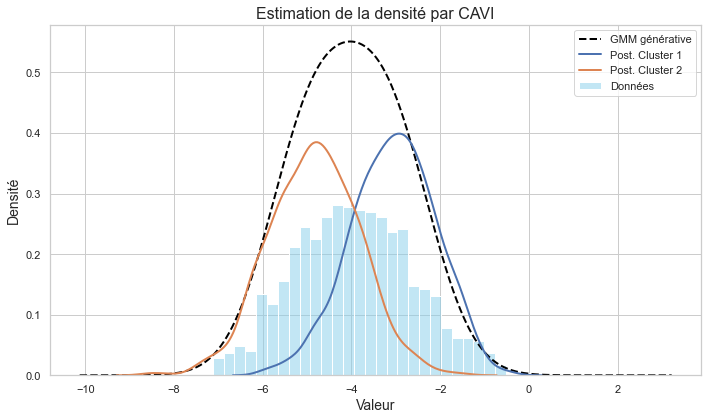

[-4730.321525100245, -4729.47045832094, -4720.74619081273, -4695.336618776982, -4629.61715259801, -4500.132987360643, -4340.4345576760325, -4227.469056411325, -4175.019438967294, -4154.577244611895, -4146.824984341302, -4143.856480379822, -4142.706187145787, -4142.256098716769, -4142.078576139535, -4142.008082587403, -4141.979926169822, -4141.968623205157, -4141.964066091512]


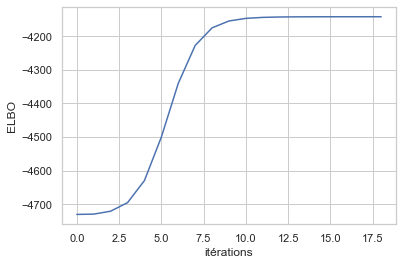

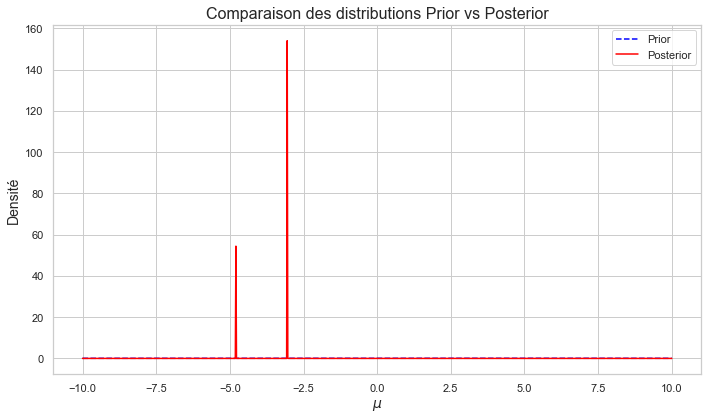

In [2]:
from cavi_poo import CAVI

In [3]:
# A faire : penser à ajouter une période de rodage
# Et regarder les auto-corrélations
# Amincissement si besoin

In [3]:
# échantillonneur de gibbs

def gibbs(mu_0, phi_0, c_0, nb_it, X, sigma):
    K = len(mu_0)
    n = len(X)

    mu_mcmc = np.empty((nb_it + 1, K))
    mu_mcmc[0] = mu_0
    c_mcmc = np.empty((nb_it + 1, n, K))
    c_mcmc[0] = c_0
    phi_mcmc = np.empty((nb_it + 1, n, K))
    phi_mcmc[0] = phi_0

    for l in range(nb_it):
        # Mise à jour sur mu
        for k in range(K):
            mu_var = 1 / (1 / sigma**2 + np.sum(phi_mcmc[l, :, k]))
            mu_mean = np.dot(X, phi_mcmc[l, :, k]) * mu_var
            mu_mcmc[l + 1, k] = np.random.normal(mu_mean, np.sqrt(mu_var))

        # Mise à jour sur les proba d'assignation (phi)
        for i in range(n):
            for k in range(K):
                phi_mcmc[l + 1, i, k] = np.exp(-(X[i] - mu_mcmc[l + 1, k])**2 / 2)
            phi_mcmc[l + 1, i, :] /= np.sum(phi_mcmc[l + 1, i, :])
            c_mcmc[l + 1, i] = np.random.multinomial(1, phi_mcmc[l + 1, i], 1)

    return mu_mcmc, c_mcmc, phi_mcmc

In [4]:
def gmm_rand(N, nb_clusters, pi, mu):
    data = np.zeros(N)
    cluster_indices = np.random.choice(nb_clusters, size=N, p=pi)
    for i in range(N):
        data[i] = np.random.normal(mu[cluster_indices[i]], 1)
    return data

def gmm_pdf(x, pi, mu):
    res = 0
    for k in range(len(pi)):
        res += pi[k] * norm.pdf(x, mu[k], 1)
    return res


In [5]:
N = 1000
nb_clusters = 2
nb_it = 1000
pi = [0.5, 0.5]
sigma = 10
np.random.seed(409)

mu_priore = [np.random.normal(0, sigma) for k in range(nb_clusters)]
donnees = gmm_rand(N, 2, pi, mu_priore)


c_0 = np.zeros((N, nb_clusters))
for i in range(N):
    c_0[i, np.random.choice(nb_clusters)] = 1

mu_0 = [np.random.normal(0, sigma) for k in range(nb_clusters)]

mu_mcmc, c_mcmc, phi_mcmc = gibbs(mu_0, pi, c_0, nb_it, donnees, sigma)


KeyboardInterrupt: 

In [11]:
# Comparaison Gibbs et CAVI
N = 1000
nb_clusters = 2
nb_it = 1000
pi = [0.5, 0.5]
sigma = 10
np.random.seed(40000)
mu_priore = [np.random.normal(0, sigma) for k in range(nb_clusters)]
donnees = gmm_rand(N, 2, pi, mu_priore)
c_0 = np.zeros((N, nb_clusters))
for i in range(N):
    c_0[i, np.random.choice(nb_clusters)] = 1

mu_0 = [np.random.normal(0, sigma) for k in range(nb_clusters)]
start_gibbs = time.time()
mu_mcmc, c_mcmc, phi_mcmc = gibbs(mu_0, pi, c_0, nb_it, donnees, sigma)
end_gibbs = time.time()
gibbs_time = end_gibbs - start_gibbs

cavi = CAVI(sigma, nb_clusters, pi, N)
cavi.mu = mu_priore
cavi.m_0 = mu_0
cavi.data = donnees
cavi.phi = c_0
start_cavi = time.time()
cavi.coordinate_ascent(50)
end_cavi = time.time()
cavi_time = end_cavi-start_cavi

print(cavi_time)
print(gibbs_time)

Iteration: 1
m_n: [-5.30721058 -5.5554133 ]
s_n: [0.00196425 0.00203625]
2
Iteration: 2
m_n: [-3.94756009 -6.90677594]
s_n: [0.00200219 0.00199702]
-11443.325001782701
Iteration: 3
m_n: [-1.87022437 -8.78253492]
s_n: [0.00206084 0.0019419 ]
-7217.530418190989
Iteration: 4
m_n: [-1.86568266 -8.78463642]
s_n: [0.00206153 0.00194129]
-6113.705643218249
Iteration: 5
m_n: [-1.86568156 -8.78463537]
s_n: [0.00206153 0.00194129]
-6114.696089660756
0.1529374122619629
29.86838984489441


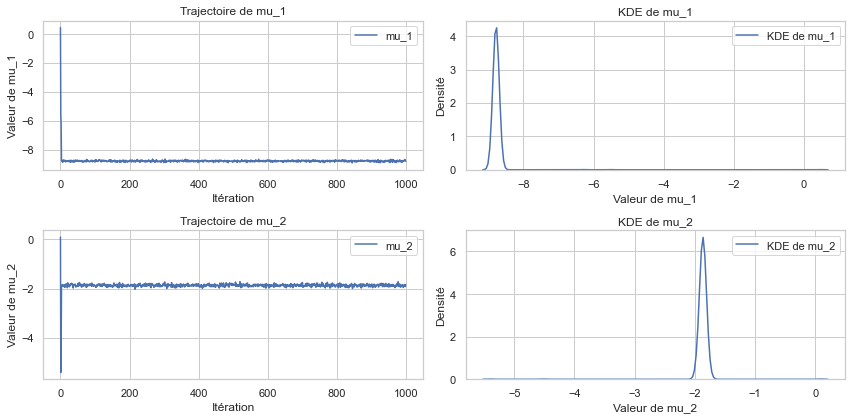

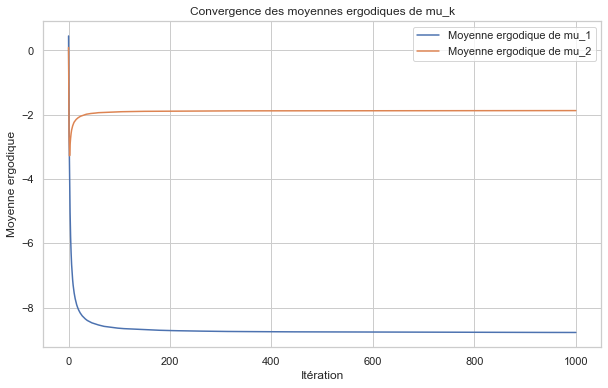

NameError: name 'xx' is not defined

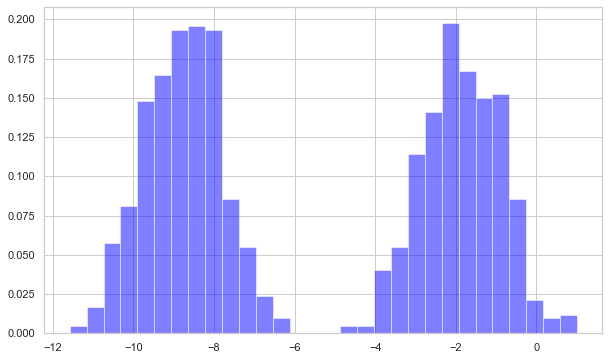

In [ ]:
# Vérification pour Gibbs

fig, axes = plt.subplots(nb_clusters, 2, figsize=(12, 6))
for k in range(nb_clusters):
    axes[k, 0].plot(mu_mcmc[:, k], label=f"mu_{k+1}")
    axes[k, 0].set_title(f"Trajectoire de mu_{k+1}")
    axes[k, 0].set_xlabel('Itération')
    axes[k, 0].set_ylabel(f'Valeur de mu_{k+1}')
    axes[k, 0].legend()

    sns.kdeplot(mu_mcmc[:, k], ax=axes[k, 1], label=f"KDE de mu_{k+1}")
    axes[k, 1].set_title(f"KDE de mu_{k+1}")
    axes[k, 1].set_xlabel(f'Valeur de mu_{k+1}')
    axes[k, 1].set_ylabel('Densité')
    axes[k, 1].legend()

plt.tight_layout()
plt.show()

mu_ergodique = np.cumsum(mu_mcmc, axis=0) / (np.arange(nb_it + 1)[:, None] + 1)

plt.figure(figsize=(10, 6))
for k in range(nb_clusters):
    plt.plot(mu_ergodique[:, k], label=f"Moyenne ergodique de mu_{k+1}")

plt.xlabel("Itération")
plt.ylabel("Moyenne ergodique")
plt.title("Convergence des moyennes ergodiques de mu_k")
plt.legend()
plt.show()

# Affichage
plt.figure(figsize=(10, 6))

# Histogramme des données générées
plt.hist(donnees, density=True, bins=30, alpha=0.5, label="Données générées", color="blue")


# Labels et légende
plt.xlabel("x")
plt.ylabel("Densité")
plt.title("Comparaison entre la prior, les données et la posterior")
plt.legend()
plt.show()


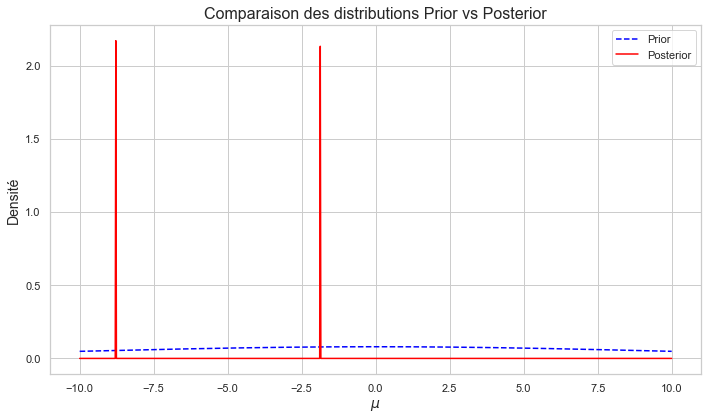

In [13]:
cavi.plot_posteriore_priore()